### One example for a lowpass filter

In [4]:
%matplotlib inline

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

# Graphing helper 
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.grid()

In [5]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

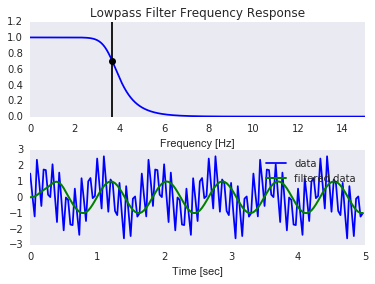

In [6]:
# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

Apply to our example with a right whale call

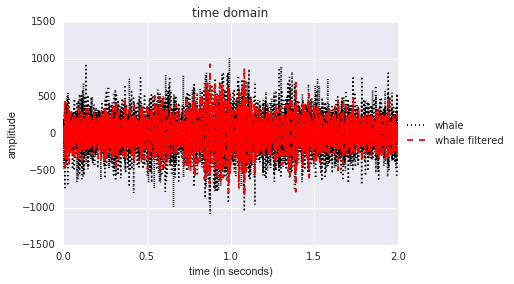

In [16]:
import pandas as pd
import seaborn as sns 
import aifc
pd.options.mode.chained_assignment = None 

#  data
trainData = pd.read_csv('data/train.csv')
# indices in Data that contain a whale call:
iWhaleCall   = [i for i, x in enumerate(trainData.label) if x == 1]
iNoWhaleCall = [i for i, x in enumerate(trainData.label) if x == 0]

clips = list(trainData.clip_name)

# data file names for example data
posFN =  'data/train/train'+str(iWhaleCall[1])+'.aiff'
negFN =  'data/train/train'+str(iNoWhaleCall[256])+'.aiff'

# open data files and sort
posSig = aifc.open(posFN, 'r')
negSig = aifc.open(negFN, 'r')


posStrSig = posSig.readframes(posSig.getnframes())
pos_y = np.fromstring(posStrSig,np.short).byteswap()

negStrSig = negSig.readframes(negSig.getnframes())
neg_y = np.fromstring(negStrSig,np.short).byteswap()

# frame rate
fs = posSig.getframerate()

# number of frames
N = posSig.getnframes()

# values
ts = 1.0/fs
t = np.arange(0,2,ts)



#=======================
# Filter requirements.
order = 6
cutoff = 450  # desired cutoff frequency of the filter, Hz

yfiltered = butter_lowpass_filter(pos_y, cutoff, fs, order)

#=======================
# before & after filtering: 
setup_graph(x_label='time (in seconds)', y_label='amplitude', title='time domain')
plt.plot(t, pos_y,'k:', label = 'whale')
plt.plot(t, yfiltered,'r--', label = 'whale filtered')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

Compare filtered vs. unfiltered spectrograms

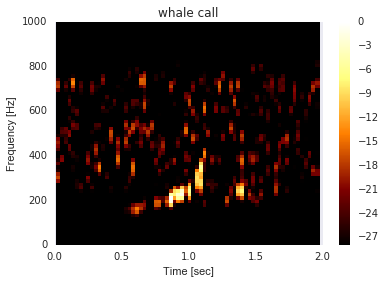

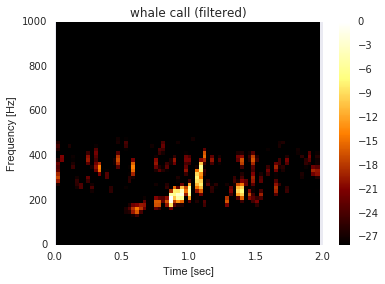

In [21]:
from scipy import signal
pos_y = signal.detrend(pos_y)
yfiltered = signal.detrend(yfiltered)
# whale call -------------------------
f, t, Sxx_pos1 = signal.spectrogram(pos_y, fs, nfft = 128, window = 'hamm',
                                   nperseg = 64, 
                                   detrend = 'constant', scaling = 'density')
Sxx_pos = 20*np.log10(Sxx_pos1/Sxx_pos1.max())
#Sxx_pos[Sxx_pos < -20] = -20

# not whale call -------------------------
f, t, Sxx_neg1 = signal.spectrogram(yfiltered, fs, nfft = 128, window = 'hamm',  
                                   nperseg = 64,  
                                   detrend = 'constant', scaling = 'density')
Sxx_neg = 20*np.log10(Sxx_neg1/Sxx_neg1.max())
#Sxx_neg[Sxx_neg < -20] = -20

figsize=(8, 15)
plt.pcolormesh(t, f, Sxx_pos, cmap = 'afmhot',vmin=-28, vmax=0)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('whale call')
plt.colorbar()
plt.show()

figsize=(8, 15)
plt.pcolormesh(t, f, Sxx_neg, cmap = 'afmhot',vmin=-28, vmax=0)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('whale call (filtered)')
plt.colorbar()
plt.show()


Compare to noise signals when filtered vs. unfiltered

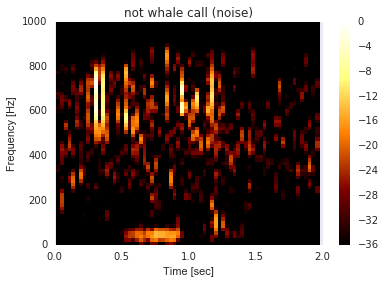

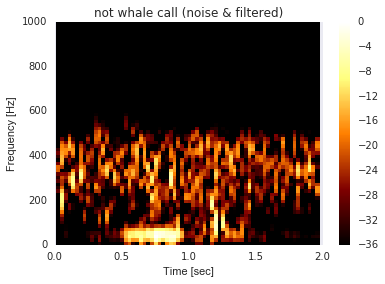

In [19]:
from scipy import signal
ynegfiltered = butter_lowpass_filter(neg_y, cutoff, fs, order)

neg_y = signal.detrend(neg_y)
ynegfiltered = signal.detrend(ynegfiltered)

# whale call -------------------------
f, t, Sxx_pos1 = signal.spectrogram(neg_y, fs, nfft = 128, window = 'hamm',
                                   nperseg = 64, 
                                   detrend = 'constant', scaling = 'density')
Sxx_pos = 20*np.log10(Sxx_pos1/Sxx_pos1.max())
#Sxx_pos[Sxx_pos < -20] = -20

# not whale call -------------------------
f, t, Sxx_neg1 = signal.spectrogram(ynegfiltered, fs, nfft = 128, window = 'hamm',  
                                   nperseg = 64,  
                                   detrend = 'constant', scaling = 'density')
Sxx_neg = 20*np.log10(Sxx_neg1/Sxx_neg1.max())
#Sxx_neg[Sxx_neg < -20] = -20

figsize=(8, 15)
plt.pcolormesh(t, f, Sxx_pos, cmap = 'afmhot',vmin=-36, vmax=0)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('not whale call (noise)')
plt.colorbar()
plt.show()

figsize=(8, 15)
plt.pcolormesh(t, f, Sxx_neg, cmap = 'afmhot',vmin=-36, vmax=0)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('not whale call (noise & filtered)')
plt.colorbar()
plt.show()
